In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns

# data exploration

In [125]:
df = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml/master/datasets/housing/housing.csv")
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
longitude             20640 non-null float64
latitude              20640 non-null float64
housing_median_age    20640 non-null float64
total_rooms           20640 non-null float64
total_bedrooms        20433 non-null float64
population            20640 non-null float64
households            20640 non-null float64
median_income         20640 non-null float64
median_house_value    20640 non-null float64
ocean_proximity       20640 non-null object
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


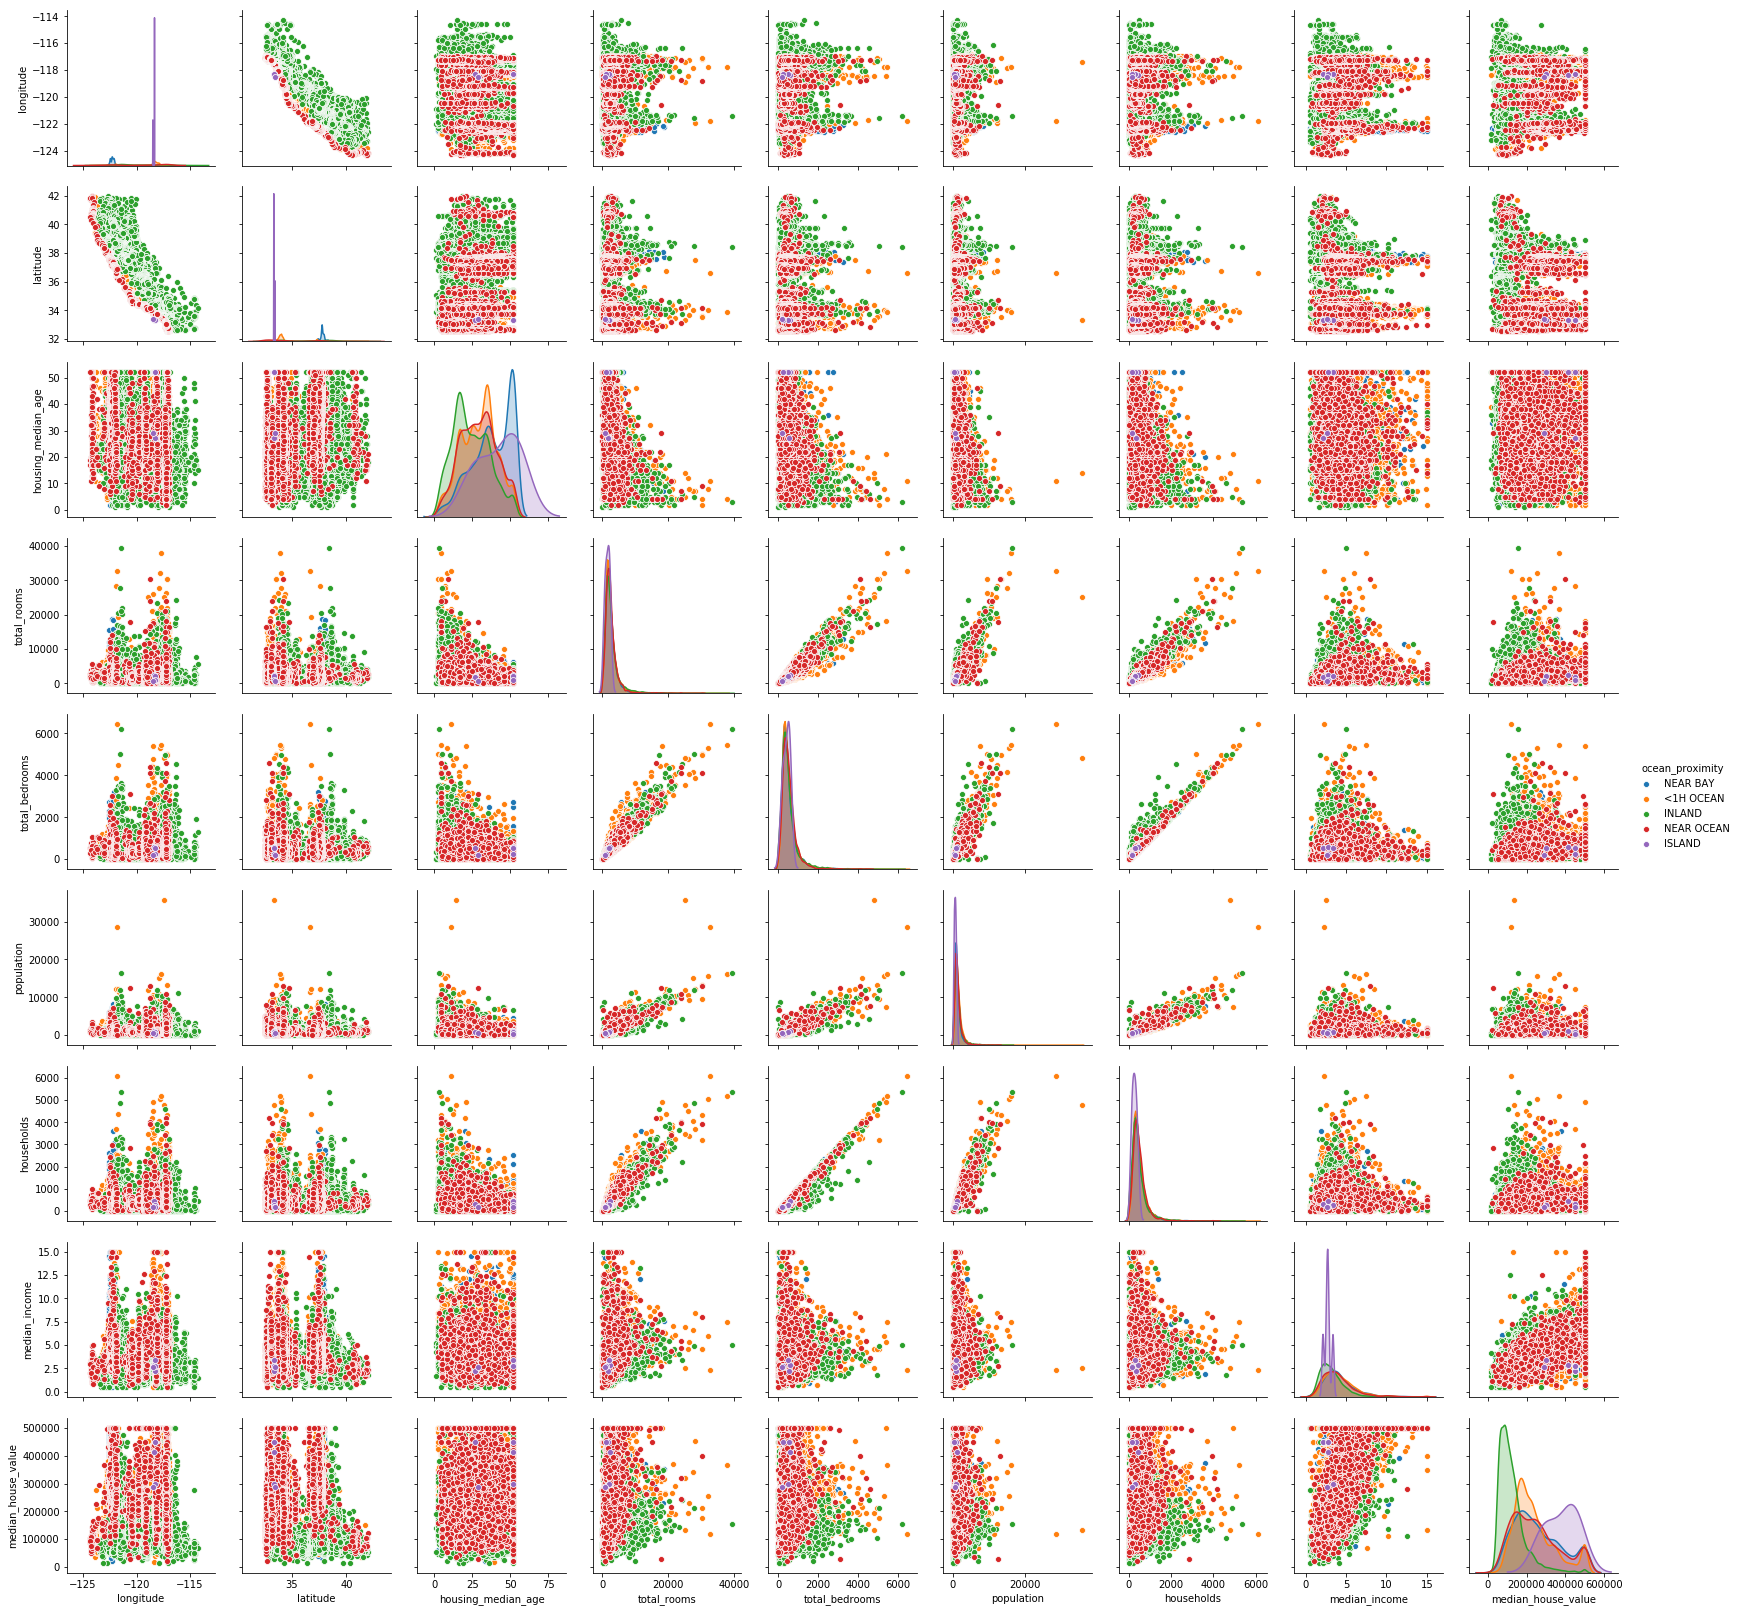

In [8]:
sns.pairplot(df,hue='ocean_proximity');

In [128]:
df['ocean_proximity'],_ = pd.factorize(df['ocean_proximity'])

# Feature engineering

In [129]:
corr = df.corr()
corr

longitude  latitude  housing_median_age  total_rooms  \
longitude            1.000000 -0.924664           -0.108197     0.044568   
latitude            -0.924664  1.000000            0.011173    -0.036100   
housing_median_age  -0.108197  0.011173            1.000000    -0.361262   
total_rooms          0.044568 -0.036100           -0.361262     1.000000   
total_bedrooms       0.069608 -0.066983           -0.320451     0.930380   
population           0.099773 -0.108785           -0.296244     0.857126   
households           0.055310 -0.071035           -0.302916     0.918484   
median_income       -0.015176 -0.079809           -0.119034     0.198050   
median_house_value  -0.045967 -0.144160            0.105623     0.134153   
ocean_proximity      0.180381 -0.067586           -0.204882     0.014818   

                    total_bedrooms  population  households  median_income  \
longitude                 0.069608    0.099773    0.055310      -0.015176   
latitude                 -0.066983   -0.108785   -0.071035      -0.079809   
housing_median_age       -0.320451   -0.296244   -0.302916      -0.119034   
total_rooms               0.930380    0.857126    0.918484       0.198050   
total_bedrooms            1.000000    0.877747    0.979728      -0.007723   
population                0.877747    1.000000    0.907222       0.004834   
households                0.979728    0.907222    1.000000       0.013033   
median_income            -0.007723    0.004834    0.013033       1.000000   
median_house_value        0.049686   -0.024650    0.065843       0.688075   
ocean_proximity           0.004081   -0.008511   -0.016911      -0.129135   

                    median_house_value  ocean_proximity  
longitude                    -0.045967         0.180381  
latitude                     -0.144160        -0.067586  
housing_median_age            0.105623        -0.204882  
total_rooms                   0.134153         0.014818  
total_bedrooms                0.049686         0.004081  
population                   -0.024650        -0.008511  
households                    0.065843        -0.016911  
median_income                 0.688075        -0.129135  
median_house_value            1.000000        -0.210600  
ocean_proximity              -0.210600         1.000000

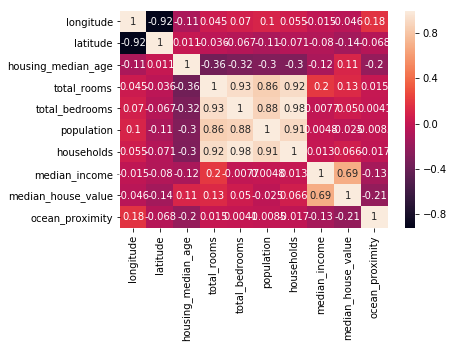

In [130]:
sns.heatmap(corr,annot=True)

In [131]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1:]


In [132]:
# Pearson correlations 
from sklearn.base import TransformerMixin, BaseEstimator

class CustomCorrelationChooser(TransformerMixin, BaseEstimator):
    def __init__(self, response, cols_to_keep=[], threshold=None):
        # store the response series
        self.response = response
        # store the threshold that we wish to keep
        self.threshold = threshold
        # initialize a variable that will eventually
        # hold the names of the features that we wish to keep
        self.cols_to_keep = cols_to_keep

    def transform(self, X):
        # the transform method simply selects the appropiate
        # columns from the original dataset
        return X[self.cols_to_keep]

    def fit(self, X, y=None):        
        corr = X.corr()
        # store names of columns that meet correlation threshold
        cols_names = X.columns[corr[self.response].abs() > self.threshold]
        self.cols_to_keep = [c for c in cols_names if c != self.response]
        return self

In [133]:
ccc = CustomCorrelationChooser(threshold=.2, response='ocean_proximity')
ccc.fit(df)
ccc.cols_to_keep

['housing_median_age', 'median_house_value']

### Conclusion on feature selection
    - using Pearson correlations with threshold of 0.2
    
    we see that the best columns using feature selection to optimize our regressor are:
    ['housing_median_age', 'median_house_value']

# Tensorflow preparation

- In this part we split the data to training and testing data. This process is called cross validation

- In Logistic regression in tensorflow we must perfom One-hot encoder on the data.

    ->One hot encoding creates new (binary) columns, indicating the presence of each possible value from the original data
        in other words
    ->One hot encoding from the sklearn.preprocessing package creates a column for every distinct value in a row in the dataset
    

In [134]:
X = df[['housing_median_age', 'median_house_value']]

In [135]:
print(X.shape,y.shape)

(20640, 2) (20640, 1)


In [136]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
X_new = encoder.fit_transform(X).toarray()
y = encoder.fit_transform(y).toarray()


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you us

In [137]:
print(X_new.shape,y.shape)

(20640, 3894) (20640, 5)


In [138]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_new, y,stratify=y, random_state=42)

# Tensorflow part

In [139]:
# Step 1 define variables constants and placeholders
inputs,outputs = X_new.shape[1],y.shape[1]

x_tensor = tf.placeholder(tf.float32,shape=[None,inputs],name='x')
y_tensor = tf.placeholder(tf.float32,shape=[None,outputs],name='y')

w = tf.Variable(tf.zeros([inputs,outputs]),dtype=tf.float32,name='w')
b = tf.Variable(tf.zeros([outputs]),dtype=tf.float32,name='b')

In [140]:
#step 2 : define model
model = tf.nn.softmax(tf.add(tf.matmul(x_tensor,w),b))

In [141]:
# Step 3 : define loss function
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=model,labels=y_tensor))

In [142]:
# Step 4 Define optimizer function
learning_rate = 0.01
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss)

In [163]:
# Step 5 : Train the model
loss_epoch=[]
epochs = 1000
testing=[]
with tf.Session() as tfs:
    tfs.run(tf.global_variables_initializer())
    for i in range(epochs+1):
        tfs.run(optimizer,feed_dict={x_tensor:X_train,y_tensor:y_train})
        feed_dict={x_tensor:X_train,y_tensor:y_train}
        lsv = tfs.run(loss,feed_dict=feed_dict)
        loss_epoch.append(lsv)
        
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(model,1),tf.arg_max(y_tensor,1)),tf.float32))
        accuracy_value = tfs.run(accuracy,feed_dict={x_tensor:X_train,y_tensor:y_train})
        testing.append(accuracy_value)
        if i%100==0:
            print("epoch {} : {}".format(i,accuracy_value))

epoch 0 : 0.6316537261009216
epoch 100 : 0.6824289560317993
epoch 200 : 0.7300387620925903
epoch 300 : 0.7476097941398621
epoch 400 : 0.7609173059463501
epoch 500 : 0.7692506313323975
epoch 600 : 0.7749999761581421
epoch 700 : 0.7793281674385071
epoch 800 : 0.7830103635787964
epoch 900 : 0.7852713465690613
epoch 1000 : 0.7875322699546814


# Visualizations

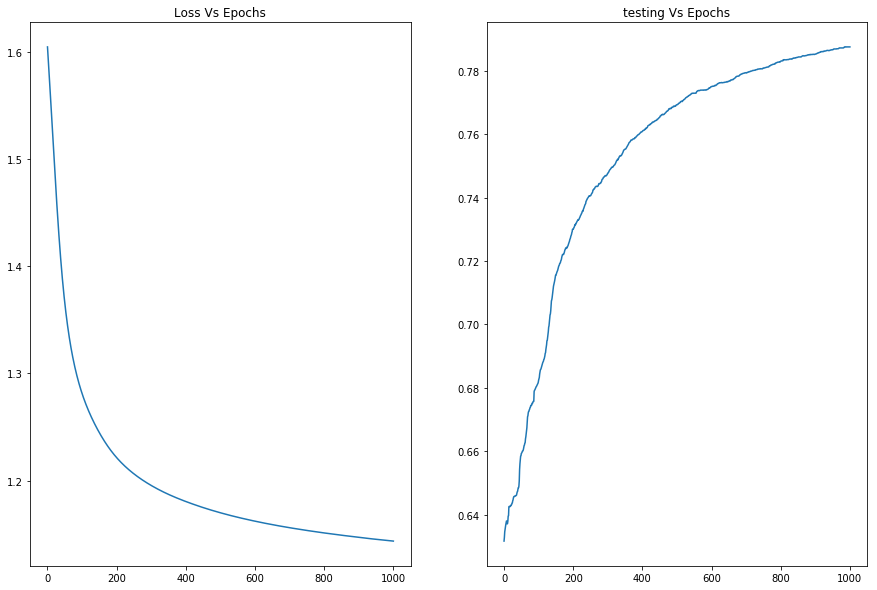

In [166]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,10))
plt.subplot(121)
plt.plot(loss_epoch)
plt.title("Loss Vs Epochs")
plt.subplot(122)
plt.plot(testing)
plt.title("testing Vs Epochs")
plt.show()